In [1]:
#importing libraries
import autograd.numpy as np
from autograd import grad, jacobian
import autograd.numpy.random as npr

import scipy.stats as si

from matplotlib import pyplot as plt
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline

import time

In [2]:
# setting up the space
nx = 20
ny = 20

dx = 1. / nx
dy = 1. / ny

x_space = np.linspace(0, 1, nx)
y_space = np.linspace(0, 1, ny)

sigma = 0.2 # volatility
r = 0.03    # riskless rate

T = 3       # maturity of the option
K = 1.1       # strike of the option
Smax = 3    # maximal value of stock

X_space_it = [(x,y) for x in x_space for y in y_space]
X_space = np.asarray(X_space_it)
Niter = nx * ny -1

x_space_r = np.random.rand(100)
y_space_r = np.random.rand(100)
X_space_r = [(x,y) for x in x_space_r for y in y_space_r]
X_space_r = np.asarray(X_space_r)

In [3]:
# black-scholes formula for scaled input T in [0,1], S in[0,Smax]
def analytic_solution(x):
    Sscale = Smax * x[1]   # scaling for x running from 0 to 1
    Tscale = T*(1-x[0])    # scaling for t running from 0 to 1
    if Tscale == 0.0:
        return np.maximum(Sscale-K,0) #np.where(Sscale-K >= 0.0, Sscale-K, 0.0) 
    else:
        d1 = (np.log(Sscale / K) + (r + 0.5 * sigma ** 2) * Tscale) / (sigma * np.sqrt(Tscale))
        d2 = d1 - sigma * np.sqrt(Tscale)
        return  (Sscale * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * Tscale) * si.norm.cdf(d2, 0.0, 1.0))

C:\Users\Kienitz_All\Anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


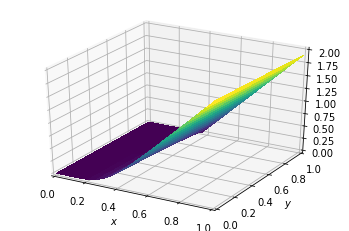

In [4]:
# plot the surface for the analytic solution
surface = np.zeros((ny, nx))

for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        surface[i][j] = analytic_solution([x, y])
        
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, surface, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 2)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [5]:
#activation functions

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def sigmoid_x(x):
    s = sigmoid(x)
    return s * (1.-s)

def sigmoid_xx(x):
    s = sigmoid(x)
    return s * (1-s) - 2. * s*s*(1-s)

def elu(x):
    return np.where(x < 0, 0.01 * (np.exp(x) - 1.), x)

In [6]:
# neural network 1 layer
Nneurons = 100                                         # number of neurons in the hidden layer
def act(x):
    sigmoid(x)

def neural_network(W, x):
    a1 = sigmoid(np.dot(x, W[0]))
    return np.dot(a1, W[1])


def neural_network_x(W,x):
    s = act(np.dot(x, W[0]))
    s *= (1-s)
    a1 = s * W[0][0]
    a2 = s * W[0][1]
    return np.array([np.dot(a1,W[1]), np.dot(a2,W[1])])

def neural_network_xx(W,x):
    s1 = elu(np.dot(x, W[0]))
    s2 = 1.-s1
    s = s1 * s2 - 2. * s1*s1*s2 
    a1 = s * W[0][0] * W[0][0]
    a2 = s * W[0][0] * W[0][1]
    a3 = a2
    a4 = s * W[0][1] * W[0][1]
    return np.array([[np.dot(a1,W[1]), np.dot(a2,W[1])],[np.dot(a2,W[1]), np.dot(a4,W[1])]])

In [7]:
# boundary conditions met with this function and function for the PDE

def f(x):
    return 0.


def A(x):
    return (1-x[0]) * np.maximum(x[1] - K / Smax,0) + x[0] * x[1] * (1-K/Smax) 
#    return (1-x[0]) * np.maximum(x[1] - K / Smax,0) + x[0] * x[1] * (1-K/Smax) 

def A_jac(x):
    x_val = - np.maximum(x[1]-K/Smax,0) + x[1] * (1-K/Smax)
    if x[1] > K/Smax:
        y_val = 1
    else:
        y_val = 0
    return np.array([x_val, y_val]) 

def A_hess(x):
    h11 = 0.0
    if x[1] > K/Smax:
        h12 = -1.0 + (1-K/Smax)
    else:
        h12 = (1-K/Smax)
    h21 = h12
    h22 = 0.0
    return np.array()

In [8]:
# function that represents the solution after training
def psy_trial(x, net_out):
    return A(x) + x[0] *  x[1] * (1 - x[1]) * net_out

def psy_trail_jac(x,net_out, net_out_jac):
    j11 = x[1]
    j11 *= (1-x[1]) * net_out
    j11 += x[0] * x[1] * (1-x[1]) * net_out_jac[0]
    
    j12 = x[0] * ((1-2*x[1])  * net_out + x[1]*(1-x[1]) * net_out_jac[1])
    j12 = j12[1]
    return A_jac(x) + np.array([j11, j12]) 

def psy_trial_hess(x,net_out):
    h11 = 1
    h12 = 2
    h21 = 3
    h22 = 4
    return A_hess(x) + np.array([[h11, h12], [h21, h22]])

#for calculating jacobian and hessian matrices
psy_t_jacob = jacobian(psy_trial)
psy_t_hess = jacobian(jacobian(psy_trial))

In [9]:
# objective function

def objective(W, iter):
    # explores the space randomly - no curse of dim
    input_point = np.array([x_space_r[iter], y_space_r[iter]])
    # explores the space using a grid - curse of dim
    #input_point = X_space_r[iter]  
    net_out = neural_network(W, input_point)[0]
            
    S = input_point[1]
    grad_val = psy_t_jacob(input_point, net_out)
    hess_val = psy_t_hess(input_point, net_out)
    gradient_of_trial_d1x = grad_val[0] #psy_t_jacobian[0]    # partial C_ij / partial t
    gradient_of_trial_d1y = grad_val[1] #psy_t_jacobian[1]    # partial C_ij / partial S
    #gradient_of_trial_d2x = psy_t_hessian[0][0] # partial C_ij / partial tt
    #gradient_of_trial_d2xy = psy_t_hessian[1][0] # partial C-ij/ partial t partial S
    gradient_of_trial_d2y = hess_val[1][1]  # partial^2 C_ij / partial S^2

#    func = f(input_point) # right part function
    # error functiont that we aim to minimize
    err = (gradient_of_trial_d1x / T -  0.5 * sigma**2 * S**2 * gradient_of_trial_d2y - r * S * gradient_of_trial_d1y + r * net_out)
    #print(err_sqr)
    #if err < 0.0:
    #    err = 5.
    err_sqr = err**2
    return np.sqrt(err_sqr)

In [10]:
#initilaize weights
W = [npr.randn(2, Nneurons), npr.randn(Nneurons, 1)]  # init the neural net
#W = W_opt
lmb = 0.01                                          # learning rate

Would it be possible to only include the boundary + using (Quasi) Randoms within the domain?

In [13]:
#new method
from autograd.misc.optimizers import adam

NBatch = 10                 # number of runs for the optimizer
Niter = 100                # at most as large as the size of the data set

gradob = grad(objective)

t0 = time.time()
for i in range(NBatch):
    if (i+1)%5 == 0: print(i+1)
    W = adam(gradob, W, step_size=0.01, num_iters=Niter) # iters is number of elemenst in xspace
    
for i in range(NBatch):
    if (i+1)%5 == 0: print(i+1)
    W = adam(gradob, W, step_size=0.001, num_iters=Niter) # iters is number of elemenst in xspace
    
for i in range(NBatch):
    if (i+1)%5 == 0: print(i+1)
    W = adam(gradob, W, step_size=0.0001, num_iters=Niter) # iters is number of elemenst in xspace
t1 = time.time()
print(t1-t0)

5
10
5
10
5
10
15.763880729675293


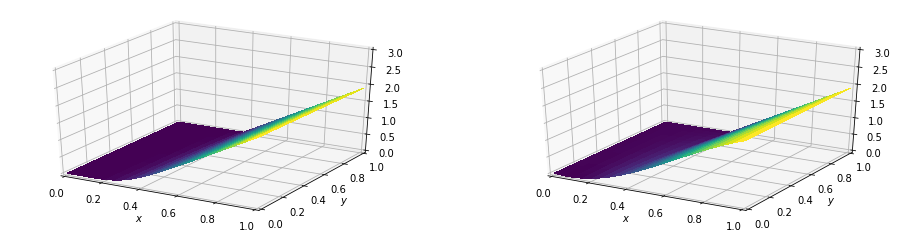

In [14]:
surface2 = np.zeros((ny, nx))
surface = np.zeros((ny, nx))

for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        surface[i][j] = analytic_solution([x, y])
        
for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        net_outt = neural_network(W, [x, y])[0]
        surface2[nx-i-1][j] = Smax * psy_trial([x, y], net_outt)
        
        
fig = plt.figure(figsize=plt.figaspect(0.25))
ax = fig.add_subplot(1, 2, 1, projection='3d') #fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, surface, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 3)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

ax = fig.add_subplot(1, 2, 2,projection='3d') #fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, surface2, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 3)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [15]:
diffsurf = surface-surface2

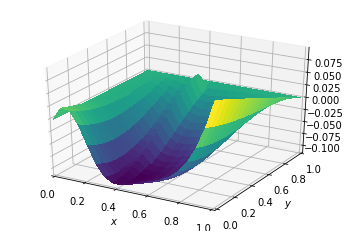

In [16]:
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, diffsurf, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(np.min(diffsurf), np.max(diffsurf))

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [17]:
#W_opt = W
#W_opt

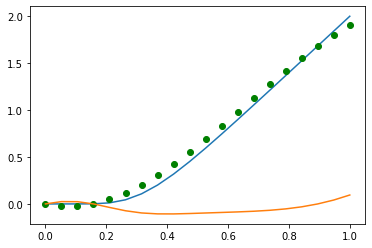

In [18]:
xindex = 0

plt.plot(y_space, surface[xindex,:])
plt.plot(y_space, surface2[xindex,:], 'go')
plt.plot(y_space, (surface[xindex,:]-surface2[xindex,:]))

In [19]:
# this defines a FNN using straight numpy to gain time advantages since numpy is faster!
NumLayers=3
Nneurons = 30                                         # number of neurons in the hidden layers

def act(x):
    return sigmoid(x)

   
def NeuralNetwork(W,x):
    input1=x
    for i in range(NumLayers):
        input1=np.dot(input1,W[0][i])+W[1][i]
        #activation
        input1=elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1,W[0][i])+W[1][i]

In [20]:
# now using a deep neural net with bias
def objective_deep(WB_deep, iter):
    input_point = np.array([x_space_r[iter], y_space_r[iter]])
    #input_point = X_space_r[iter]   
    net_out = NeuralNetwork(WB_deep, input_point)[0]
            
    S = input_point[1]
    grad_val = psy_t_jacob(input_point, net_out)
    hess_val = psy_t_hess(input_point, net_out)
    gradient_of_trial_d1x = grad_val[0][0]  # partial C_ij / partial t
    gradient_of_trial_d1y = grad_val[0][1]  # partial C_ij / partial S
    #gradient_of_trial_d2x = psy_t_hessian[0][0][0] # partial C_ij / partial tt
    #gradient_of_trial_d2xy = psy_t_hessian[0][1][0] # partial C-ij/ partial t partial S
    gradient_of_trial_d2y = hess_val[0][1][1]  # partial^2 C_ij / partial S^2

#    func = f(input_point) # right part function
    # error functiont that we aim to minimize
    err = (gradient_of_trial_d1x / T -  0.5 * sigma**2 * S**2 * gradient_of_trial_d2y - r * S * gradient_of_trial_d1y + r * net_out)
    #print(err_sqr)
    #if err < 0.0:
    #    err = 5.
    err_sqr = err**2
    return err_sqr

In [21]:
#Initialize the weights and the biases
W_deep=[]                                             # weights
B_deep=[]                                             # biases

#input layer
W_deep.append(npr.randn(2,Nneurons))                  # randomly choose the weights
B_deep.append(npr.randn(1,Nneurons))                  # randomly choose the biases

#hidden layers
for i in range(NumLayers-1):
    W_deep.append(npr.randn(Nneurons, Nneurons))
    B_deep.append(npr.randn(1,Nneurons))

#output layer
W_deep.append(npr.randn(Nneurons,1))
B_deep.append(npr.randn(1,1))

WB_deep = [W_deep, B_deep]                            # one variable carrying the weights and the biases

In [22]:
#new method
from autograd.misc.optimizers import adam

NBatch = 10
Niter = 100
gradob = grad(objective_deep)

t0 = time.time()
for i in range(NBatch):
    if (i+1)%5 == 0: print(i+1)
    WB_deep = adam(gradob, WB_deep, step_size=0.01, num_iters=Niter) # iters is number of elemenst in xspace

for i in range(NBatch):
    if (i+1)%5 == 0: print(i+1)
    WB_deep = adam(gradob, WB_deep, step_size=0.001, num_iters=Niter) # iters is number of elemenst in xspace

for i in range(NBatch):
    if (i+1)%5 == 0: print(i+1)
    WB_deep = adam(gradob, WB_deep, step_size=0.0001, num_iters=Niter) # iters is number of elemenst in xspace
t1 = time.time()
print(t1-t0)

5
10
5
10
5
10
24.13948082923889


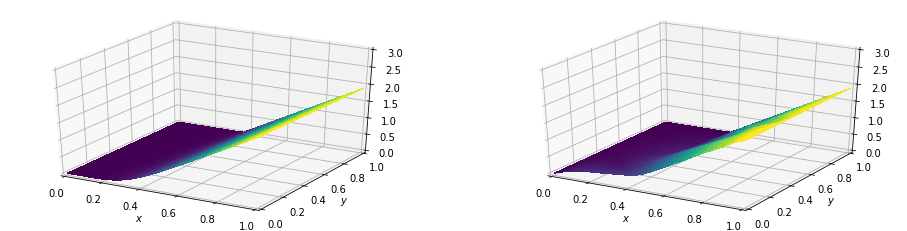

In [23]:
surface2 = np.zeros((ny, nx))
surface = np.zeros((ny, nx))

for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        surface[i][j] = analytic_solution([x, y])
        
for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):
        net_outt = NeuralNetwork(WB_deep, [x, y])[0]
        surface2[nx-i-1][j] = Smax * psy_trial([x, y], net_outt)
        
        
fig = plt.figure(figsize=plt.figaspect(0.25))
ax = fig.add_subplot(1, 2, 1, projection='3d') #fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, surface, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 3)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

ax = fig.add_subplot(1, 2, 2,projection='3d') #fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, surface2, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 3)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');




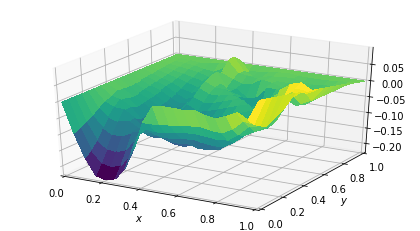

In [24]:
diffsurf = surface-surface2
fig = plt.figure(figsize=plt.figaspect(0.25))
ax = fig.add_subplot(1, 2, 1, projection='3d') #fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, diffsurf, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(np.min(diffsurf), np.max(diffsurf))

ax.set_xlabel('$x$')
ax.set_ylabel('$y$');



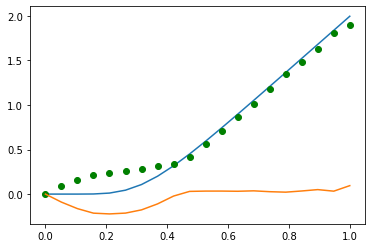

In [25]:
xindex = 0
ax = fig.add_subplot(1, 2, 2)
plt.plot(y_space, surface[xindex,:])
plt.plot(y_space, surface2[xindex,:], 'go')
plt.plot(y_space, (surface[xindex,:]-surface2[xindex,:]))